### Setup & data loading

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

In [10]:
data_m = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)
factors = pd.read_csv("../../../data/processed/yield_curve_factors.csv", index_col=0, parse_dates=True)

# merge and keep monthly index
df = pd.concat([data_m, factors], axis=1).sort_index()
df = df.asfreq("ME")
df

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,PC1_Level,PC2_Slope,PC3_Curvature
1959-01-31,2.484194,NaN,NaN,29.010,286.6,3352.129,6.0,NaN,NaN,NaN,NaN,NaN,8.117351,5.658088,NaN,NaN,NaN
1959-02-28,2.428571,NaN,NaN,29.000,287.7,3352.129,5.9,NaN,NaN,NaN,NaN,NaN,8.117351,5.661918,NaN,NaN,NaN
1959-03-31,2.803871,NaN,NaN,28.970,289.2,3352.129,5.6,NaN,NaN,NaN,NaN,NaN,8.117351,5.667118,NaN,NaN,NaN
1959-04-30,2.958333,NaN,NaN,28.980,290.1,3427.667,5.2,NaN,NaN,NaN,NaN,NaN,8.139635,5.670226,NaN,NaN,NaN
1959-05-31,2.895161,NaN,NaN,29.040,292.2,3427.667,5.1,NaN,NaN,NaN,NaN,NaN,8.139635,5.677438,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,4.330000,3.889000,4.383500,321.500,22022.1,NaN,4.1,0.494500,2.672683,4.540578,2.080467,1.657317,NaN,9.999802,-1.110089,1.231662,0.553339
2025-07-31,4.330000,3.882273,4.391818,322.132,22115.8,NaN,4.2,0.509545,2.731801,4.823657,1.245417,1.598199,NaN,10.004048,-1.107968,1.205456,0.572929
2025-08-31,4.330000,3.703810,4.264762,323.364,22195.4,NaN,4.3,0.560952,2.939220,4.767929,1.245417,1.390780,NaN,10.007640,-1.394995,1.176283,0.644525
2025-09-30,4.224667,3.568571,4.120476,324.368,NaN,NaN,NaN,0.551905,3.022700,4.339937,1.245417,1.201967,NaN,NaN,-1.737024,1.112223,0.567918


In [11]:
usrec = web.DataReader("USREC", "fred", start=df.index[0]).resample("ME").last()
df = df.join(usrec, how="inner")
df.rename(columns={"USREC":"recession"}, inplace=True)
df["recession"] = df["recession"].astype(int)
df

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,PC1_Level,PC2_Slope,PC3_Curvature,recession
1959-02-28,2.428571,NaN,NaN,29.000,287.7,3352.129,5.9,NaN,NaN,NaN,NaN,NaN,8.117351,5.661918,NaN,NaN,NaN,0
1959-03-31,2.803871,NaN,NaN,28.970,289.2,3352.129,5.6,NaN,NaN,NaN,NaN,NaN,8.117351,5.667118,NaN,NaN,NaN,0
1959-04-30,2.958333,NaN,NaN,28.980,290.1,3427.667,5.2,NaN,NaN,NaN,NaN,NaN,8.139635,5.670226,NaN,NaN,NaN,0
1959-05-31,2.895161,NaN,NaN,29.040,292.2,3427.667,5.1,NaN,NaN,NaN,NaN,NaN,8.139635,5.677438,NaN,NaN,NaN,0
1959-06-30,3.391667,NaN,NaN,29.110,294.1,3427.667,5.0,NaN,NaN,NaN,NaN,NaN,8.139635,5.683920,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31,4.330000,3.920000,4.423810,320.580,21884.6,NaN,4.2,0.503810,2.375934,4.223796,2.080467,1.954066,NaN,9.993538,-1.069582,1.170613,0.486321,0
2025-06-30,4.330000,3.889000,4.383500,321.500,22022.1,NaN,4.1,0.494500,2.672683,4.540578,2.080467,1.657317,NaN,9.999802,-1.110089,1.231662,0.553339,0
2025-07-31,4.330000,3.882273,4.391818,322.132,22115.8,NaN,4.2,0.509545,2.731801,4.823657,1.245417,1.598199,NaN,10.004048,-1.107968,1.205456,0.572929,0
2025-08-31,4.330000,3.703810,4.264762,323.364,22195.4,NaN,4.3,0.560952,2.939220,4.767929,1.245417,1.390780,NaN,10.007640,-1.394995,1.176283,0.644525,0


### Construct the prediction target (12-month ahead recession)

In [12]:
H = 12
df["recession_t+h"] = df["recession"].shift(-H).astype("float")
# drop last H months with unknown future label
df_model = df.dropna(subset=["recession_t+h"]).copy()
df_model

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,PC1_Level,PC2_Slope,PC3_Curvature,recession,recession_t+h
1959-02-28,2.428571,NaN,NaN,29.000,287.7,3352.129,5.9,NaN,NaN,NaN,NaN,NaN,8.117351,5.661918,NaN,NaN,NaN,0,0.0
1959-03-31,2.803871,NaN,NaN,28.970,289.2,3352.129,5.6,NaN,NaN,NaN,NaN,NaN,8.117351,5.667118,NaN,NaN,NaN,0,0.0
1959-04-30,2.958333,NaN,NaN,28.980,290.1,3427.667,5.2,NaN,NaN,NaN,NaN,NaN,8.139635,5.670226,NaN,NaN,NaN,0,0.0
1959-05-31,2.895161,NaN,NaN,29.040,292.2,3427.667,5.1,NaN,NaN,NaN,NaN,NaN,8.139635,5.677438,NaN,NaN,NaN,0,1.0
1959-06-30,3.391667,NaN,NaN,29.110,294.1,3427.667,5.0,NaN,NaN,NaN,NaN,NaN,8.139635,5.683920,NaN,NaN,NaN,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,5.330000,4.856364,4.482273,313.140,20997.7,23286.508,4.0,-0.374091,3.238866,0.944657,3.126632,2.091134,10.055629,9.952168,-0.001381,2.264414,0.273200,0,0.0
2024-06-30,5.330000,4.736842,4.305263,313.131,21065.6,23286.508,4.1,-0.431579,2.970085,1.361228,3.126632,2.359915,10.055629,9.955397,-0.270239,2.447966,0.351443,0,0.0
2024-07-31,5.330000,4.495909,4.248636,313.566,21098.1,23478.570,4.2,-0.247273,2.938463,1.569413,2.791390,2.391537,10.063843,9.956938,-0.510698,2.357208,0.507883,0,0.0
2024-08-31,5.330000,3.965455,3.870909,314.131,21185.3,23478.570,4.2,-0.094545,2.610914,2.113087,2.791390,2.719086,10.063843,9.961063,-1.327569,2.472460,0.739478,0,0.0


### Features and quick sanity

In [13]:
# Use contemporaneous predictors to forecast 12m ahead (no peeking into the future)
X_cols_base = ["PC2_Slope"]                       # core predictor
X_cols_plus = ["PC2_Slope", "inflation_yoy", "UNRATE"]  # optional macro controls

# to be safe with missing, fill fwd/back tiny gaps
df_model[X_cols_plus] = df_model[X_cols_plus].fillna(method="ffill").fillna(method="bfill")

# add constant
X_base = sm.add_constant(df_model[X_cols_base])
X_plus = sm.add_constant(df_model[X_cols_plus])

y = df_model["recession_t+h"]

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_2851/516191257.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model[X_cols_plus] = df_model[X_cols_plus].fillna(method="ffill").fillna(method="bfill")


### In-sample logistic with HAC (robust) errors

In [16]:
logit_base = sm.Logit(y, X_base).fit(
    disp=0,
    cov_type='HAC',
    cov_kwds={'maxlags': 12}
)
logit_base.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: recession_t+h    Pseudo R-squared: 0.034     
Date:               2025-10-25 20:07 AIC:              564.0665  
No. Observations:   788              BIC:              573.4055  
Df Model:           1                Log-Likelihood:   -280.03   
Df Residuals:       786              LL-Null:          -290.01   
Converged:          1.0000           LLR p-value:      7.9152e-06
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -2.0484    0.3117  -6.5727  0.0000  -2.6593  -1.4376
PC2_Slope      0.5086    0.2360   2.1552  0.0311   0.0461   0.9711
=================================================================

"""

In [17]:
logit_plus = sm.Logit(y, X_plus).fit(
    disp=0,
    cov_type='HAC',
    cov_kwds={'maxlags': 12}
)
logit_plus.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: recession_t+h    Pseudo R-squared: 0.152     
Date:               2025-10-25 20:08 AIC:              500.1375  
No. Observations:   788              BIC:              518.8155  
Df Model:           3                Log-Likelihood:   -246.07   
Df Residuals:       784              LL-Null:          -290.01   
Converged:          1.0000           LLR p-value:      6.2269e-19
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
const          -0.9827    1.3352  -0.7359  0.4618  -3.5997  1.6344
PC2_Slope       0.2331    0.3597   0.6481  0.5169  -0.4719  0.9381
inflation_yoy   0.2905    0.0912   3.1869  0.0014   0.1119  0.4692
UNRATE         -0.4284    0.2345  -1.8268  0.0677  -0.8880  0.0312
=================================================================

"""

### In-sample classification quality (ROC / PR)

AUC (base): 0.636 | AP (base): 0.184
AUC (plus): 0.810 | AP (plus): 0.289


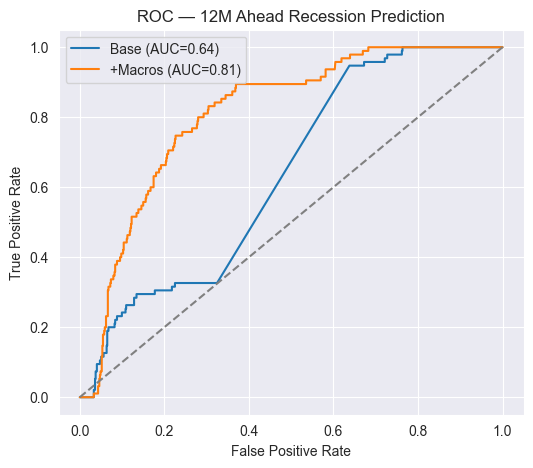

In [18]:
phat_base = logit_base.predict(X_base)
phat_plus = logit_plus.predict(X_plus)

auc_base = roc_auc_score(y, phat_base)
auc_plus = roc_auc_score(y, phat_plus)

ap_base = average_precision_score(y, phat_base)
ap_plus = average_precision_score(y, phat_plus)

print(f"AUC (base): {auc_base:.3f} | AP (base): {ap_base:.3f}")
print(f"AUC (plus): {auc_plus:.3f} | AP (plus): {ap_plus:.3f}")

# ROC plot
fpr_b, tpr_b, _ = roc_curve(y, phat_base)
fpr_p, tpr_p, _ = roc_curve(y, phat_plus)

plt.figure(figsize=(6,5))
plt.plot(fpr_b, tpr_b, label=f"Base (AUC={auc_base:.2f})")
plt.plot(fpr_p, tpr_p, label=f"+Macros (AUC={auc_plus:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — 12M Ahead Recession Prediction")
plt.legend()
plt.show()

### Walk-forward backtest

In [24]:
# CELL 8 (robust OOS loop using scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

start_idx = 180   # require ~15y of history before first OOS prediction; bump if needed
min_pos = 5       # require at least 5 positive (recession) samples in training
min_neg = 60      # require at least 60 negative samples in training (imbalance guard)

dates = df_model.index
oos_dates, oos_phat, oos_y = [], [], []

Xname = X_cols_base[0]  # 'PC2_Slope' in our setup

for t in range(start_idx, len(dates)):
    train_end = t
    train_idx = slice(0, train_end)
    test_idx  = t

    ytr = df_model["recession_t+h"].iloc[train_idx].astype(int)
    Xtr = df_model[[Xname]].iloc[train_idx].values  # shape (n,1)
    xte = df_model[[Xname]].iloc[[test_idx]].values # shape (1,1)

    # guards: need both classes and minimum counts
    n_pos = int((ytr == 1).sum())
    n_neg = int((ytr == 0).sum())
    if n_pos < min_pos or n_neg < min_neg:
        # skip until enough information exists
        continue

    # model: standardized logistic regression, L2, class_weight balanced
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("logit", LogisticRegression(
            penalty="l2",
            C=1.0,                # strength of regularization (lower = stronger)
            solver="lbfgs",
            class_weight="balanced",
            max_iter=200
        ))
    ])

    pipe.fit(Xtr, ytr)
    phat = pipe.predict_proba(xte)[0, 1].item()

    oos_dates.append(dates[test_idx])
    oos_phat.append(phat)
    oos_y.append(int(df_model["recession_t+h"].iloc[test_idx]))

oos = pd.DataFrame({"phat": oos_phat, "y": oos_y}, index=pd.DatetimeIndex(oos_dates))
oos.head(), oos.tail(), oos["y"].value_counts()


(            phat  y
 1974-02-28   0.5  1
 1974-03-31   0.5  1
 1974-04-30   0.5  0
 1974-05-31   0.5  0
 1974-06-30   0.5  0,
                 phat  y
 2024-05-31  0.817052  0
 2024-06-30  0.832374  0
 2024-07-31  0.820190  0
 2024-08-31  0.828277  0
 2024-09-30  0.803726  0,
 y
 0    548
 1     60
 Name: count, dtype: int64)

OOS AUC (base): 0.700 | OOS AP: 0.182


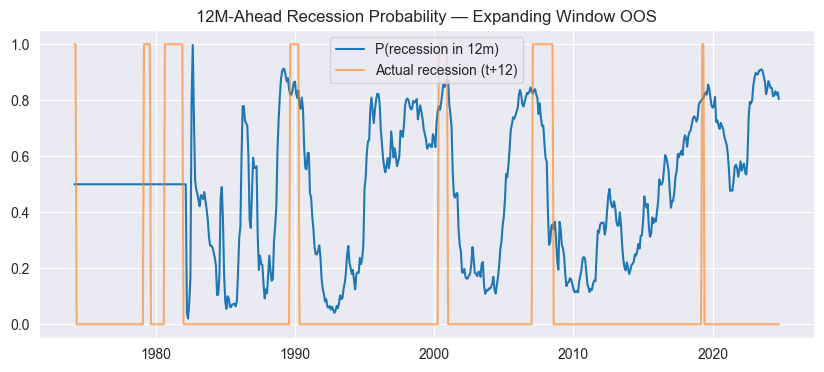

In [25]:
# CELL 9: OOS metrics and visualization
oos_auc = roc_auc_score(oos["y"], oos["phat"])
oos_ap  = average_precision_score(oos["y"], oos["phat"])
print(f"OOS AUC (base): {oos_auc:.3f} | OOS AP: {oos_ap:.3f}")

plt.figure(figsize=(10,4))
plt.plot(oos.index, oos["phat"], label="P(recession in 12m)")
plt.plot(oos.index, oos["y"], label="Actual recession (t+12)", alpha=0.6)
plt.title("12M-Ahead Recession Probability — Expanding Window OOS")
plt.legend(); plt.show()

In [28]:
# CELL 10: choose threshold by maximizing TPR - FPR on OOS
fpr, tpr, thr = roc_curve(oos["y"], oos["phat"])
j = np.argmax(tpr - fpr)
thr_star = thr[j]
print(thr_star)

0.5


In [30]:
# CELL 11: confusion matrix @ optimal threshold
pred = (oos["phat"] >= thr_star).astype(int)
TP = int(((pred == 1) & (oos["y"] == 1)).sum())
FP = int(((pred == 1) & (oos["y"] == 0)).sum())
TN = int(((pred == 0) & (oos["y"] == 0)).sum())
FN = int(((pred == 0) & (oos["y"] == 1)).sum())

print(f"Threshold={thr_star:.2f} | TP={TP} FP={FP} TN={TN} FN={FN}")
print(f"Precision={TP/(TP+FP+1e-9):.2f}  Recall={TP/(TP+FN+1e-9):.2f}")


Threshold=0.50 | TP=55 FP=291 TN=257 FN=5
Precision=0.16  Recall=0.92


| Metric               | Meaning                                      | Your value | Interpretation                                              |
| -------------------- | -------------------------------------------- | ---------- | ----------------------------------------------------------- |
| **TP = 55**          | correctly predicted recessions               | —          | the model captures most true recessions                     |
| **FP = 291**         | false alarms                                 | —          | many high-probability spikes that didn’t lead to recessions |
| **TN = 257**         | correctly predicted expansions               | —          | moderate number of correct “no-recession” calls             |
| **FN = 5**           | missed recessions                            | —          | very few; recall = 0.92                                     |
| **Precision = 0.16** | share of predicted recessions that were real | low        | signals often come early or overshoot                       |
| **Recall = 0.92**    | share of real recessions that were predicted | high       | nearly every recession was caught                           |


In [32]:
# If 2s10s isn't already in df_model, create it (percentage points)
if "spread_10y_2y" not in df_model.columns:
    if {"DGS10", "DGS2"}.issubset(df_model.columns):
        df_model["spread_10y_2y"] = df_model["DGS10"] - df_model["DGS2"]
    else:
        raise ValueError("Need DGS10 and DGS2 in df_model to build 2s10s spread.")

# Small sanity check
df_model[["PC2_Slope", "spread_10y_2y"]].dropna()

,PC2_Slope,spread_10y_2y
1976-06-30,-0.077729,0.801364
1976-07-31,-0.077729,0.981905
1976-08-31,-0.077729,1.137273
1976-09-30,-0.077729,1.178095
1976-10-31,-0.077729,1.427000
...,...,...
2024-05-31,2.264414,-0.374091
2024-06-30,2.447966,-0.431579
2024-07-31,2.357208,-0.247273
2024-08-31,2.472460,-0.094545


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import numpy as np
import pandas as pd

def oos_prob_series(dfm, feature_name, target_col="recession_t+h",
                    start_idx=180, min_pos=5, min_neg=60,
                    C=1.0, max_iter=200):
    dates = dfm.index
    oos_dates, oos_phat, oos_y = [], [], []

    pipe = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("logit", LogisticRegression(
            penalty="l2", C=C, solver="lbfgs",
            class_weight="balanced", max_iter=max_iter
        ))
    ])

    # Drop NaN rows for the feature or target
    dfm = dfm.dropna(subset=[feature_name, target_col])

    for t in range(start_idx, len(dfm)):
        train_idx = slice(0, t)
        Xtr = dfm[[feature_name]].iloc[train_idx].values
        ytr = dfm[target_col].iloc[train_idx].astype(int).values

        # Skip degenerate samples
        n_pos = (ytr == 1).sum(); n_neg = (ytr == 0).sum()
        if n_pos < min_pos or n_neg < min_neg:
            continue

        pipe.fit(Xtr, ytr)
        xte = dfm[[feature_name]].iloc[[t]].values
        phat = pipe.predict_proba(xte)[0, 1].item()

        oos_dates.append(dfm.index[t])
        oos_phat.append(phat)
        oos_y.append(int(dfm[target_col].iloc[t]))

    return pd.DataFrame({"phat": oos_phat, "y": oos_y}, index=pd.DatetimeIndex(oos_dates))


def summarize_oos(oos_df):
    auc = roc_auc_score(oos_df["y"], oos_df["phat"])
    ap  = average_precision_score(oos_df["y"], oos_df["phat"])
    fpr, tpr, thr = roc_curve(oos_df["y"], oos_df["phat"])
    # Choose threshold by Youden J (TPR-FPR)
    j = np.argmax(tpr - fpr)
    thr_star = thr[j]
    pred = (oos_df["phat"] >= thr_star).astype(int)
    TP = int(((pred==1)&(oos_df["y"]==1)).sum())
    FP = int(((pred==1)&(oos_df["y"]==0)).sum())
    TN = int(((pred==0)&(oos_df["y"]==0)).sum())
    FN = int(((pred==0)&(oos_df["y"]==1)).sum())
    prec = TP / (TP + FP + 1e-9)
    rec  = TP / (TP + FN + 1e-9)
    return {"AUC": auc, "AP": ap, "thr": float(thr_star),
            "TP": TP, "FP": FP, "TN": TN, "FN": FN,
            "Precision": prec, "Recall": rec, "fpr": fpr, "tpr": tpr}


In [38]:
# Fill or drop NaNs before modeling
df_model = df_model.copy()

# Option 1: forward-fill time series gaps (preferred for macro data)
df_model = df_model.ffill()

# # Option 2 (safer if early NaNs or structural gaps exist)
# df_model = df_model.dropna(subset=["PC2_Slope", "spread_10y_2y", "recession_t+h"])


# OOS series
oos_pca = oos_prob_series(df_model, "PC2_Slope", start_idx=180)
oos_spd = oos_prob_series(df_model, "spread_10y_2y", start_idx=180)

# Summaries
sum_pca = summarize_oos(oos_pca)
sum_spd = summarize_oos(oos_spd)

pd.DataFrame({
    "Model": ["PCA Slope", "2s10s Spread"],
    "AUC":   [sum_pca["AUC"], sum_spd["AUC"]],
    "AP":    [sum_pca["AP"], sum_spd["AP"]],
    "Thr*":  [sum_pca["thr"], sum_spd["thr"]],
    "Precision@Thr*": [sum_pca["Precision"], sum_spd["Precision"]],
    "Recall@Thr*":    [sum_pca["Recall"], sum_spd["Recall"]],
    "TP": [sum_pca["TP"], sum_spd["TP"]],
    "FP": [sum_pca["FP"], sum_spd["FP"]],
    "TN": [sum_pca["TN"], sum_spd["TN"]],
    "FN": [sum_pca["FN"], sum_spd["FN"]],
})


,Model,AUC,AP,Thr*,Precision@Thr*,Recall@Thr*,TP,FP,TN,FN
0,PCA Slope,0.699939,0.182428,0.500000,0.158960,0.916667,55,291,257,5
1,2s10s Spread,0.712558,0.167329,0.588718,0.205479,0.535714,15,58,314,13


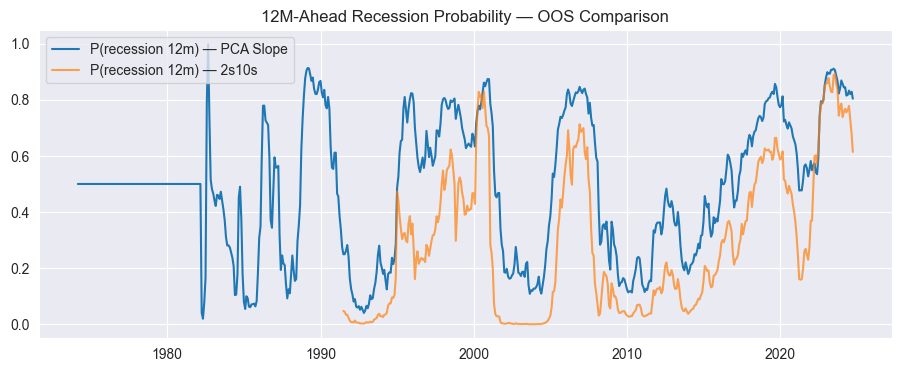

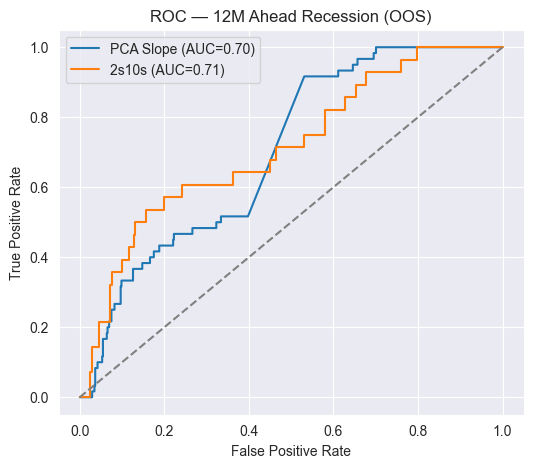

In [39]:
import matplotlib.pyplot as plt

# Probability series overlay
plt.figure(figsize=(11,4))
plt.plot(oos_pca.index, oos_pca["phat"], label="P(recession 12m) — PCA Slope")
plt.plot(oos_spd.index, oos_spd["phat"], label="P(recession 12m) — 2s10s", alpha=0.7)
plt.title("12M-Ahead Recession Probability — OOS Comparison")
plt.legend(); plt.show()

# ROC overlay
plt.figure(figsize=(6,5))
plt.plot(sum_pca["fpr"], sum_pca["tpr"], label=f"PCA Slope (AUC={sum_pca['AUC']:.2f})")
plt.plot(sum_spd["fpr"], sum_spd["tpr"], label=f"2s10s (AUC={sum_spd['AUC']:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — 12M Ahead Recession (OOS)")
plt.legend(); plt.show()
